# ISIDORA-PYX

In [1]:
from __future__ import print_function
from IPython.display import Image
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%load_ext line_profiler

In [4]:
ic = %env ICDIR

In [5]:
import line_profiler

In [6]:
ic

'/Users/jjgomezcadenas/Documents/Development/NEXT/IC'

In [7]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import pandas as pd
import tables as tb
import numpy as np
import tables

In [9]:
from system_of_units import *

In [10]:
from Util import *

In [11]:
import FEParam as FP
import SPE as SP
import FEE2 as FE
from scipy import signal as SGN 

In [12]:
from Configure import *

In [13]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [32]:
import tblFunctions as tbl

In [14]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [15]:
from scipy import signal as SGN 

In [16]:
import time

In [17]:
%load_ext Cython

In [18]:
import cProfile

### ISIDORA-PYX revisited on:

In [19]:
print(time.strftime("%d/%m/%Y"))

20/10/2016


In [20]:
print(time.strftime("%H:%M:%S"))

09:39:42


In [25]:
# %load ../../../Cities/ISIDORA.py
"""
ISIDORA
JJGC Agusut 2016

What ISIDORA does:
1) Reads a RWF file written by DIOMIRA
2) Performs DBLR
3) Write the corrected waveforms (CWF) to the file as new Evectors.

Change Log:
18/10 JJG added cython module
"""

from __future__ import print_function

import sys
from time import time
import numpy as np
import tables

import system_of_units as units
from LogConfig import logger
from Configure import configure, define_event_loop

import FEParam as FP
import coreFunctions as cf
import cBLR

CYTHON = True


def accumulator_coefficients(CA,NPMT,len_WF):
    """
    Compute the accumulator coefficients for DBLR
    It computes the inverse function of the HPF and takes
    the accumulator as the value of the function anywhere
    but the first bin (the inverse is a step function with
    constant value equal to the accumulator)
    CA are the values of the capacitances defining the filter
    (1/(2CR)) for each PMT
    """
    coef_acc = np.zeros(NPMT, dtype=np.double)

    signal_t = np.arange(0.0, len_WF*1., 1., dtype=np.double)

    for j in range(NPMT):
        fee = FE.FEE(C=CA[j], R=FP.R, f=FP.freq_LPF, RG=FP.V_GAIN)
        signal_inv_daq = fee.InverseSignalDAQ(signal_t)  # inverse function
        coef_acc[j] = signal_inv_daq[10] # any index is valid, function is flat

    return coef_acc


def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
         thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC):
    """
    Peform Base line Restoration
    coeff_acc is an array with the coefficients of the accumulator
    Threshold 1 is used to decide when raw signal raises up above trigger line
    Threshold 2 is used to decide when reconstructed signal is above trigger line
    Threshold 3 is used to compare Raw and Rec signal
    """

    len_WF = pmtrd.shape[2]
    NPMT = pmtrd.shape[1]
    BLRS =[]

    for j in range(NPMT):
        sgn_raw = FP.ceiling - pmtrd[event_number, j]
        sgn_rec, MAU, pulse_on, wait_over = cBLR.BLR(sgn_raw,
                                                 coeff_acc[j],
                                                 mau_len, thr1, thr2, thr3)

        BLRS.append((sgn_rec, MAU, pulse_on, wait_over))

    return zip(*BLRS)


def ISIDORA(argv):
    DEBUG_LEVEL, INFO, CFP = configure(argv[0],argv[1:])

    if INFO:

        print("""
        ISIDORA:
        1. Reads an Nh5 file produced by DIOMIRA, which stores the
            raw waveforms (RWF) for the PMTs and SiPMs waveforms, as well as
            data on geometry, sensors and MC. The RDWF of the PMTs
            show negative swing due to the HPF of the EP FEE electronics

        2. Performs DBLR on the PMT RWF and produces corrected waveforms (CWF).

        3. Adds the CWF and ancilliary info to the DST

        4. Computes the energy of the PMTs per each event and writes to DST

        """)

    PATH_IN = CFP['PATH_IN']
    FILE_IN = CFP['FILE_IN']
    FIRST_EVT = CFP['FIRST_EVT']
    LAST_EVT = CFP['LAST_EVT']
    RUN_ALL = CFP['RUN_ALL']
    COEF = CFP['COEF']
    CA = cf.farray_from_string(CFP['CA'])*units.nF
    AC = cf.farray_from_string(CFP['AC'])
    MAU_LEN = CFP['MAU_LEN']
    NSIGMA1 = CFP['NSIGMA1']
    NSIGMA2 = CFP['NSIGMA2']
    NSIGMA3 = CFP['NSIGMA3']

    NEVENTS = LAST_EVT - FIRST_EVT

    logger.info('Debug level = {}'.format(DEBUG_LEVEL))

    logger.info("input path ={}; file_in ={} ".format(
        PATH_IN,FILE_IN))

    logger.info("""first event = {} last event = {}
                    nof events requested = {} """.format(FIRST_EVT,
                                                         LAST_EVT,
                                                         NEVENTS))

    logger.info("""MAU length = {}
                   n_sigma1 = {} n_sigma2 = {} """.format(MAU_LEN,
                                                          NSIGMA1,
                                                          NSIGMA2))
    logger.info("CA  = {} nF ".format(CA/units.nF))
    logger.info("Accumulator Coefficients = {}  ".format(AC))

    # open the input file in mode append
    with tables.open_file("{}/{}".format(PATH_IN, FILE_IN), "a") as h5in:
        # access the PMT raw data in file
        pmtrd_ = h5in.root.RD.pmtrwf     # PMT raw data must exist

        #pmtrd_.shape = (nof_events, nof_sensors, wf_length)
        NEVENTS_DST, NPMT, PMTWL = pmtrd_.shape

        logger.info("nof PMTs = {} WF side = {} ".format(NPMT, PMTWL))
        logger.info("nof events in input DST = {} ".format(NEVENTS_DST))

        # create an extensible array to store the CWF waveforms
        # if it exists remove and create again
        if '/RD/pmtcwf' in h5in:
            pmtcwf = h5in.root.RD.pmtcwf
            h5in.remove_node("/RD","pmtcwf")

        pmtcwf = h5in.create_earray(h5in.root.RD, "pmtcwf",
                                atom=tables.Int16Atom(),
                                shape=(0, NPMT, PMTWL),
                                expectedrows=NEVENTS_DST)

        # create a group to store BLR configuration
        # mau, acummulator, pulse_on and wait_over stored for pmt 0
        # baseline stored for all PMTs.
        if not '/BLR' in h5in:
            rgroup = h5in.create_group(h5in.root, "BLR")

        if '/BLR/mau' in h5in:
            mau = h5in.root.BLR.mau
            h5in.remove_node("/BLR","mau")
        mau = h5in.create_earray(h5in.root.BLR, "mau",
                                atom=tables.Int16Atom(),
                                shape=(0, PMTWL),
                                expectedrows=NEVENTS_DST)

        if '/BLR/pulse_on' in h5in:
            pulse_on = h5in.root.BLR.pulse_on
            h5in.remove_node("/BLR","pulse_on")
        pulse_on = h5in.create_earray(h5in.root.BLR, "pulse_on",
                                atom=tables.Int16Atom(),
                                shape=(0, PMTWL),
                                expectedrows=NEVENTS_DST)

        if '/BLR/wait_over' in h5in:
            wait_over = h5in.root.BLR.wait_over
            h5in.remove_node("/BLR","wait_over")
        wait_over = h5in.create_earray(h5in.root.BLR, "wait_over",
                                atom=tables.Int16Atom(),
                                shape=(0, PMTWL),
                                expectedrows=NEVENTS_DST)

        # compute the accumulator coefficients from the nominal values
        # of capacitances (if COEF =0) or use previously computed coeff
        coeff_acc = accumulator_coefficients(CA,
                                             NPMT, PMTWL) if COEF == 0 else AC

        # LOOP
        first_evt, last_evt = define_event_loop(FIRST_EVT, LAST_EVT,
                                                NEVENTS, NEVENTS_DST, RUN_ALL)

        t0 = time()
        for i in range(first_evt,last_evt):

            logger.info("-->event number ={}".format(i))
            signal_r, xmau, pulse_, wait_ = DBLR(pmtrd_, i, coeff_acc,
                                                 mau_len=MAU_LEN,
                                                 thr1 = NSIGMA1*FP.NOISE_ADC,
                                                 thr2=NSIGMA2*FP.NOISE_ADC,
                                                 thr3 = NSIGMA3*FP.NOISE_ADC)
            # append to pmtcwd
            pmtcwf.append(np.array(signal_r).reshape(1, NPMT, PMTWL))

            # append BLR variables
            mau.append(xmau[0].reshape(1, PMTWL))
            pulse_on.append (pulse_[0].reshape(1, PMTWL))
            wait_over.append(wait_[0].reshape(1, PMTWL))

        t1 = time()
        pmtcwf.flush()
        mau.flush()
        pulse_on.flush()
        wait_over.flush()

        print("ISIDORA has run over {} events in {} seconds".format(i+1,
                                                                    t1-t0))
    print("Leaving ISIDORA. Safe travels!")

#if __name__ == '__main__':

    #ISIDORA(sys.argv)


In [22]:
less ../../../Config/ISIDORA_NA_ZLIB_test2.csv

In [26]:
ISIDORA(['ISIDORA','-d','INFO','-c''../../../Config/ISIDORA_NA_ZLIB_test2.csv'])

INFO:root:Debug level = INFO


Debug level = INFO


INFO:root:input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 


INFO:root:first event = 0 last event = 10
                    nof events requested = 10 


first event = 0 last event = 10
                    nof events requested = 10 


INFO:root:MAU length = 250
                   n_sigma1 = 2.0 n_sigma2 = 2.0 


MAU length = 250
                   n_sigma1 = 2.0 n_sigma2 = 2.0 


INFO:root:CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 


INFO:root:Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  


INFO:root:nof PMTs = 12 WF side = 48000 


nof PMTs = 12 WF side = 48000 


INFO:root:nof events in input DST = 10 


nof events in input DST = 10 


INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 10 events in 4.80532002449 seconds
Leaving ISIDORA. Safe travels!


In [28]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test2.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
                   n_sigma1 = 2.0 n_sigma2 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.46922707558 seconds
Leaving ISIDORA. Safe travels!


In [ ]:
Timer unit: 1e-06 s

Total time: 9.83155 s
File: <ipython-input-25-b37245159f5d>
Function: DBLR at line 222

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
   222                                           def DBLR(pmtrd, event_number, coeff_acc, mau_len=250,
   223                                                    thr1 = FP.NOISE_ADC, thr2=0, thr3 = FP.NOISE_ADC, log='INFO'):
   224                                               """
   225                                               Peform Base line Restoration
   226                                               coeff_acc is an array with the coefficients of the accumulator
   227                                               Threshold 1 is used to decide when raw signal raises up above trigger line
   228                                               Threshold 2 is used to decide when reconstructed signal is above trigger line
   229                                               Threshold 3 is used to compare Raw and Rec signal
   230                                               """
   231         1            2      2.0      0.0      perform_blr = lambda wf,coef: BLR(FP.ceiling - wf, coef, mau_len, thr1, thr2, thr3, log)
   232         1      9831551 9831551.0    100.0      return map( perform_blr, pmtrd[event_number], coeff_acc )

### Checking file

In [29]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [30]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/mau (EArray(10, 48000), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 32768)
/BLR/pulse_on (EArray(10, 48000), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 32768)
/BLR/wait_over (EArray(10, 48000), shuffle, zlib(1)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 32768)
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1)

In [39]:
pmttwf, sipmtwf, pmtrwf, pmtblr, sipmrwf, pmtdf, sipmdf, gdf, dFEE = tbl.get_vectors(h5f)

In [41]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

#### event 0

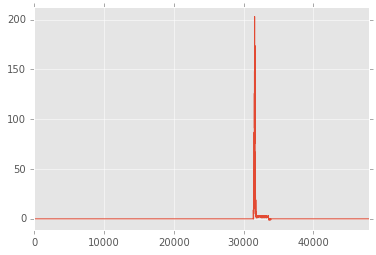

In [42]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

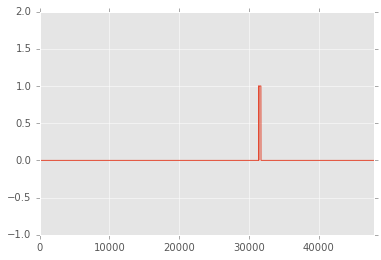

In [43]:
mpl.plts(pulse_on[0], signal_start=0, signal_end=48000, offset=1)

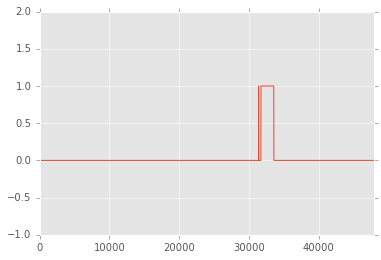

In [44]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

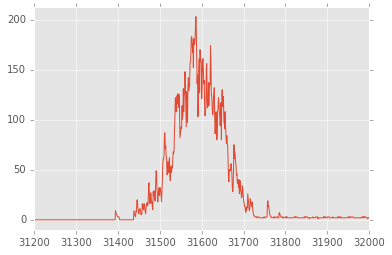

In [46]:
mpl.plts(pmtcwf[0,0], signal_start=31200, signal_end=32000, offset=10)

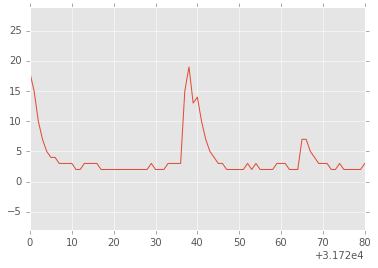

In [48]:
mpl.plts(pmtcwf[0,0], signal_start=31720, signal_end=31800, offset=10)

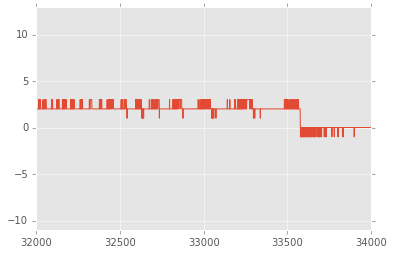

In [49]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=34000, offset=10)

#### event 1

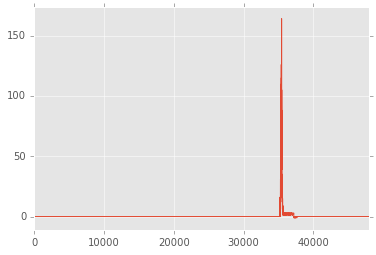

In [253]:
mpl.plts(pmtcwf[1,0], signal_start=0, signal_end=48000, offset=10)

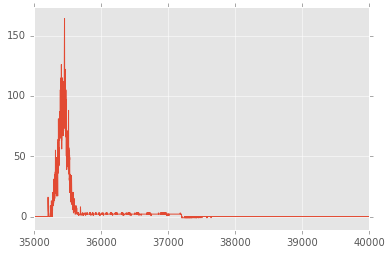

In [254]:
mpl.plts(pmtcwf[1,0], signal_start=35000, signal_end=40000, offset=10)

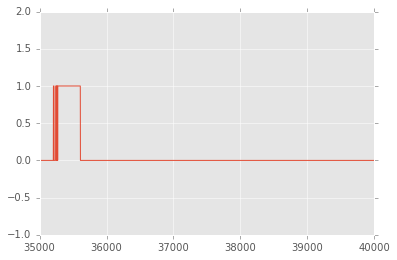

In [260]:
mpl.plts(pulse_on[1], signal_start=35000, signal_end=40000, offset=1)

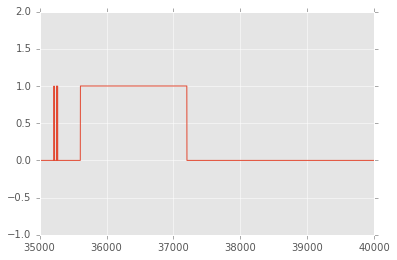

In [261]:
mpl.plts(wait_over[1], signal_start=35000, signal_end=40000, offset=1)

#### event 2

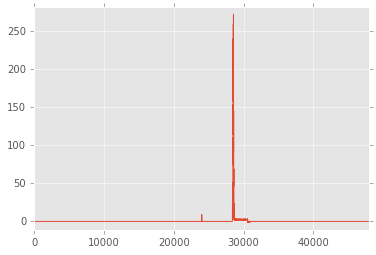

In [244]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

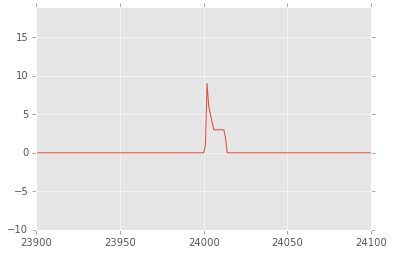

In [243]:
mpl.plts(pmtcwf[2,0], signal_start=23900, signal_end=24100, offset=10)

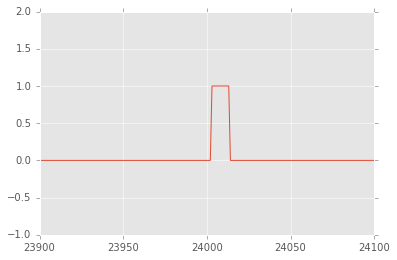

In [263]:
mpl.plts(pulse_on[2], signal_start=23900, signal_end=24100, offset=1)

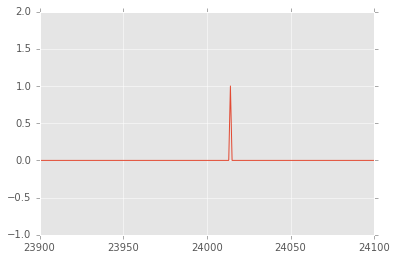

In [264]:
mpl.plts(wait_over[2], signal_start=23900, signal_end=24100, offset=1)

##### Mau

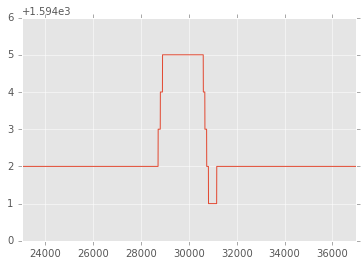

In [245]:
mpl.plts(mau[2], signal_start=23000, signal_end=37000, offset=1)

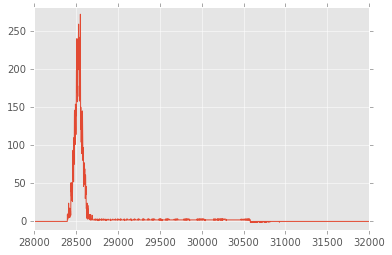

In [266]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

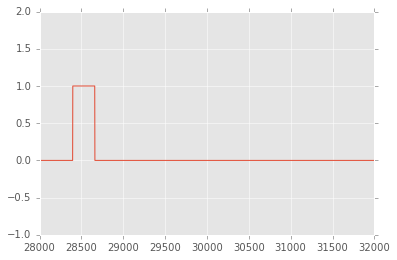

In [267]:
mpl.plts(pulse_on[2], signal_start=28000, signal_end=32000, offset=1)

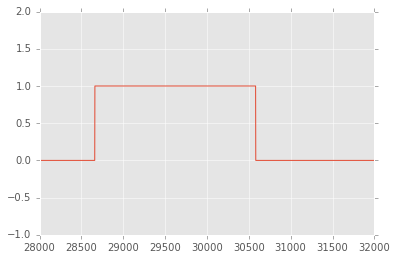

In [268]:
mpl.plts(wait_over[2], signal_start=28000, signal_end=32000, offset=1)

#### event 3

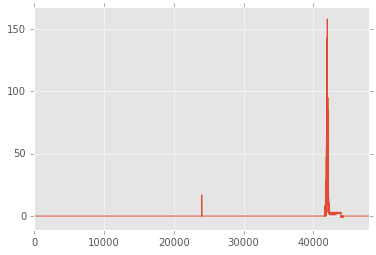

In [275]:
mpl.plts(pmtcwf[3,0], signal_start=0, signal_end=48000, offset=10)

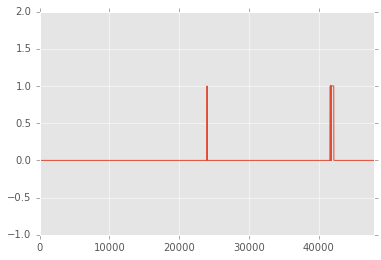

In [273]:
mpl.plts(pulse_on[3], signal_start=0, signal_end=48000, offset=1)

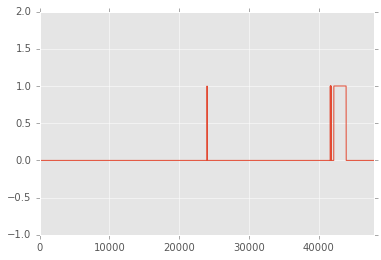

In [274]:
mpl.plts(wait_over[3], signal_start=0, signal_end=48000, offset=1)

#### event 4

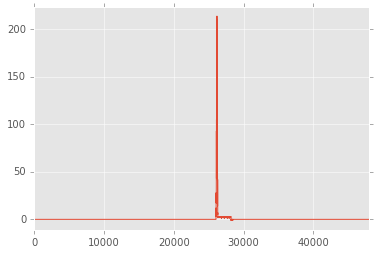

In [279]:
mpl.plts(pmtcwf[4,0], signal_start=0, signal_end=48000, offset=10)

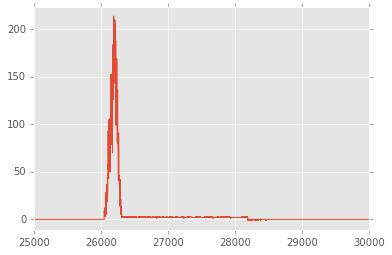

In [280]:
mpl.plts(pmtcwf[4,0], signal_start=25000, signal_end=30000, offset=10)

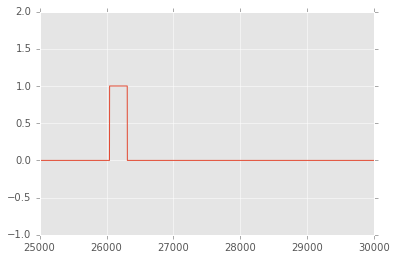

In [281]:
mpl.plts(pulse_on[4], signal_start=25000, signal_end=30000, offset=1)

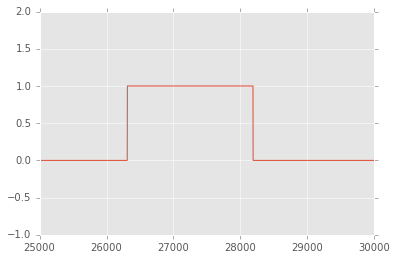

In [282]:
mpl.plts(wait_over[4], signal_start=25000, signal_end=30000, offset=1)

#### event 5

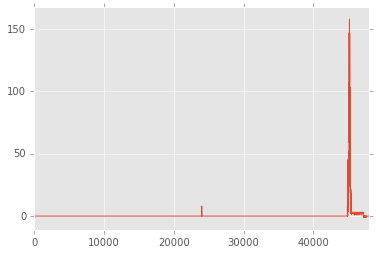

In [290]:
mpl.plts(pmtcwf[5,0], signal_start=0, signal_end=48000, offset=10)

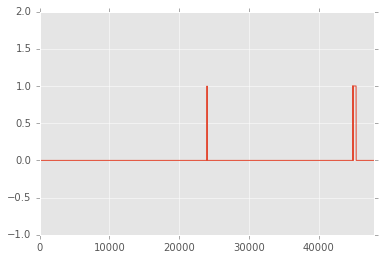

In [291]:
mpl.plts(pulse_on[5], signal_start=0, signal_end=48000, offset=1)

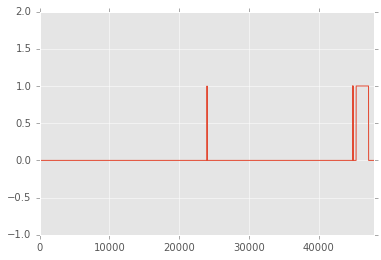

In [292]:
mpl.plts(wait_over[5], signal_start=0, signal_end=48000, offset=1)

#### event 6

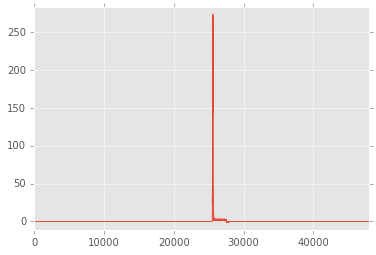

In [283]:
mpl.plts(pmtcwf[6,0], signal_start=0, signal_end=48000, offset=10)

#### event 7

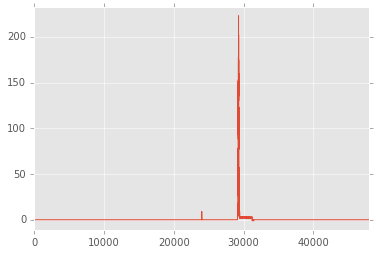

In [284]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

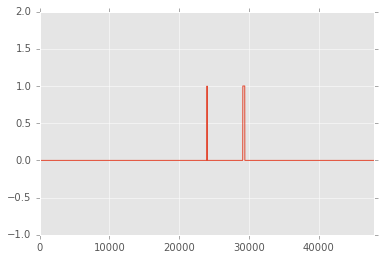

In [286]:
mpl.plts(pulse_on[7], signal_start=0, signal_end=48000, offset=1)

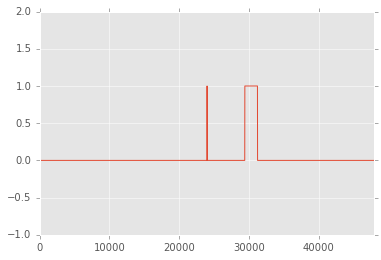

In [287]:
mpl.plts(wait_over[7], signal_start=0, signal_end=48000, offset=1)

#### event 8

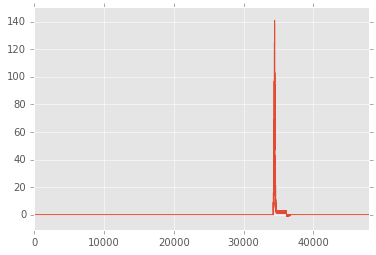

In [288]:
mpl.plts(pmtcwf[8,0], signal_start=0, signal_end=48000, offset=10)

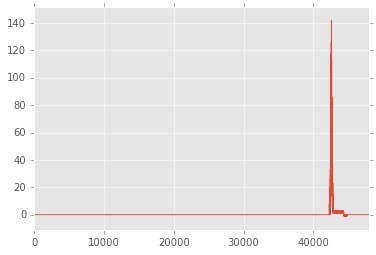

In [289]:
mpl.plts(pmtcwf[9,0], signal_start=0, signal_end=48000, offset=10)

#### Set (2,2,5)

This set of thresholds is stable (we always seem to recover the baseline), but has the annoying side feature of a long pedestal afther the signal is over, at about the same value used for the trheshold. 

#### Set(5,0,2) 

In [51]:
less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [52]:
h5f.close()

In [54]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma2 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 2.99451994896 seconds
Leaving ISIDORA. Safe travels!


In [56]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [57]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

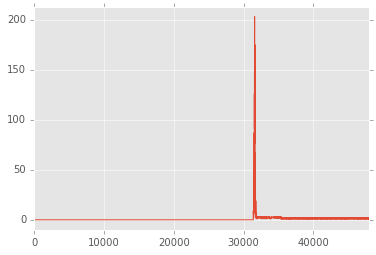

In [58]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

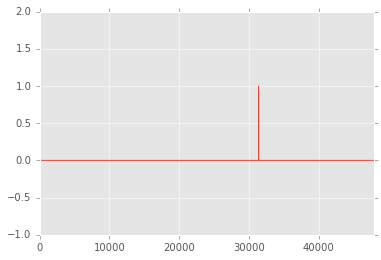

In [59]:
mpl.plts(pulse_on[0], signal_start=0, signal_end=48000, offset=1)

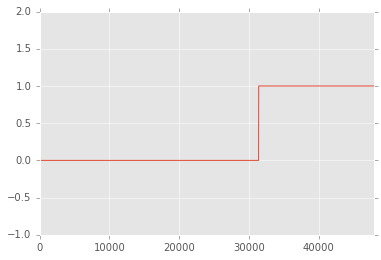

In [60]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

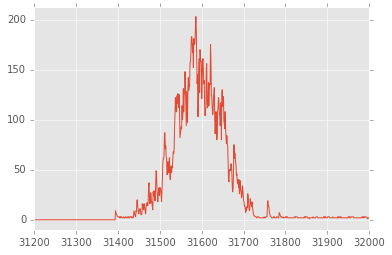

In [61]:
mpl.plts(pmtcwf[0,0], signal_start=31200, signal_end=32000, offset=10)

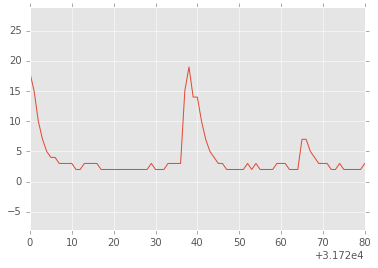

In [62]:
mpl.plts(pmtcwf[0,0], signal_start=31720, signal_end=31800, offset=10)

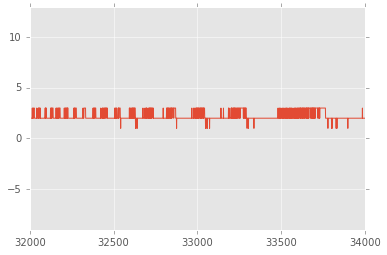

In [63]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=34000, offset=10)

#### We do not recover baseline

#### Set(5,0,3) 

In [64]:
less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [65]:
h5f.close()

In [66]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma2 = 3.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 3.74112010002 seconds
Leaving ISIDORA. Safe travels!


In [68]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [69]:
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

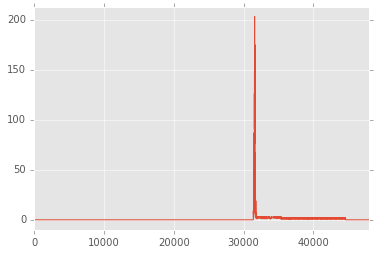

In [70]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

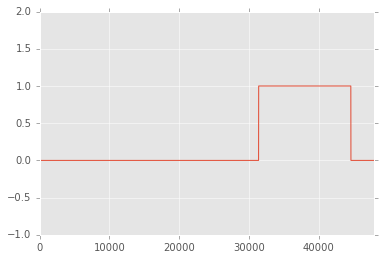

In [71]:
mpl.plts(wait_over[0], signal_start=0, signal_end=48000, offset=1)

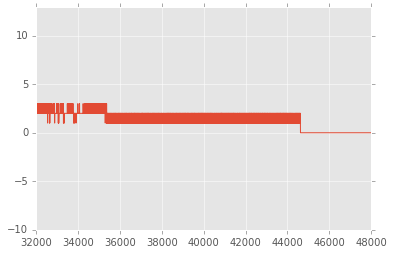

In [73]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=48000, offset=10)

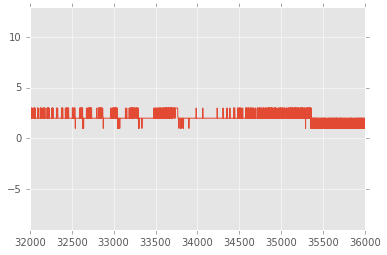

In [74]:
mpl.plts(pmtcwf[0,0], signal_start=32000, signal_end=36000, offset=10)

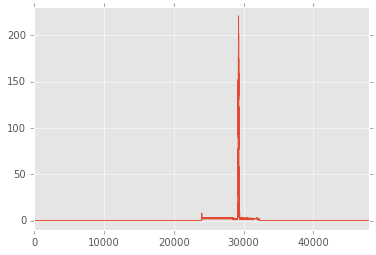

In [75]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

##### Without thr2 we do not recover well S1

##### (3,0,5)

In [84]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [85]:
h5f.close()

In [86]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 0.0 n_sigma2 = 5.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.42155098915 seconds
Leaving ISIDORA. Safe travels!


In [87]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')

In [88]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

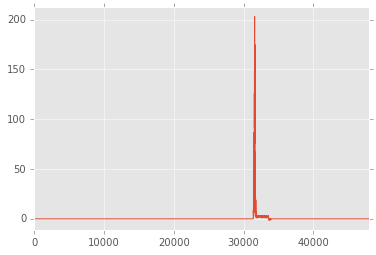

In [89]:
mpl.plts(pmtcwf[0,0], signal_start=0, signal_end=48000, offset=10)

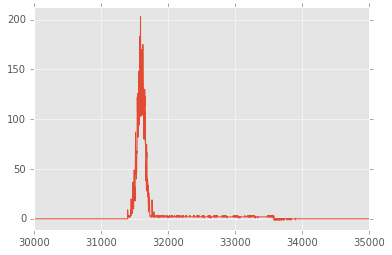

In [98]:
mpl.plts(pmtcwf[0,0], signal_start=30000, signal_end=35000, offset=10)

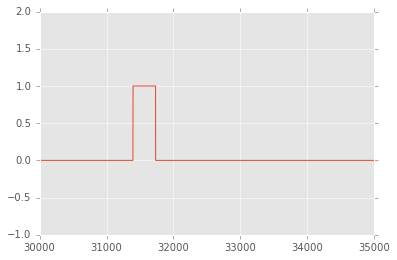

In [100]:
mpl.plts(pulse_on[0], signal_start=30000, signal_end=35000, offset=1)

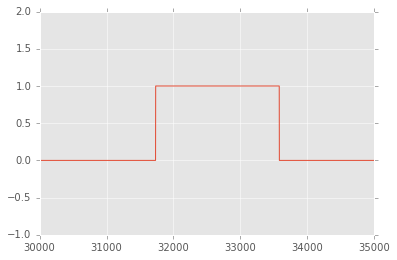

In [101]:
mpl.plts(wait_over[0], signal_start=30000, signal_end=35000, offset=1)

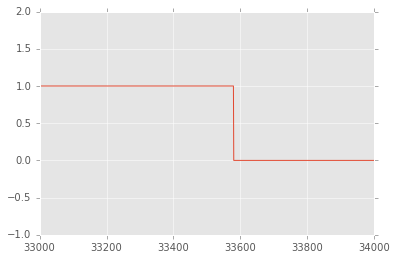

In [102]:
mpl.plts(wait_over[0], signal_start=33000, signal_end=34000, offset=1)

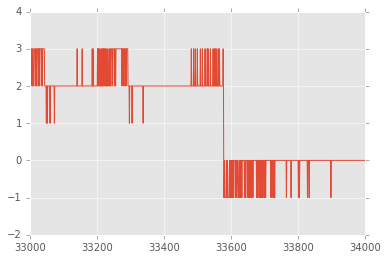

In [103]:
mpl.plts(pmtcwf[0,0], signal_start=33000, signal_end=34000, offset=1)

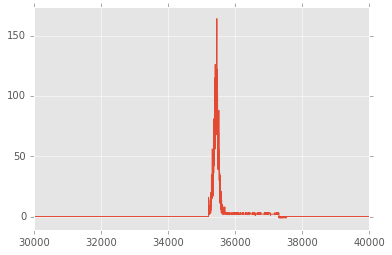

In [105]:
mpl.plts(pmtcwf[1,0], signal_start=30000, signal_end=40000, offset=10)

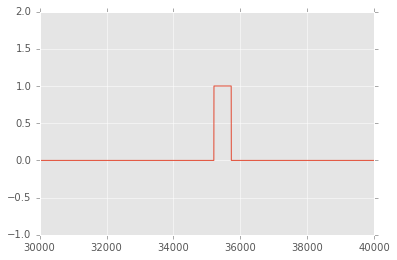

In [106]:
mpl.plts(pulse_on[1], signal_start=30000, signal_end=40000, offset=1)

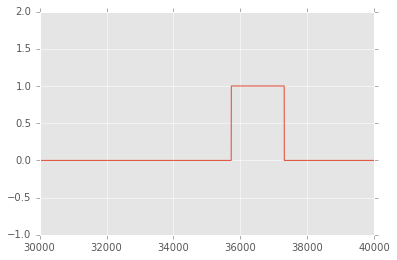

In [108]:
mpl.plts(wait_over[1], signal_start=30000, signal_end=40000, offset=1)

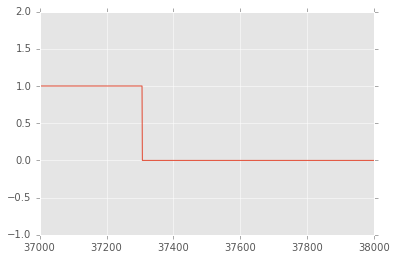

In [109]:
mpl.plts(wait_over[1], signal_start=37000, signal_end=38000, offset=1)

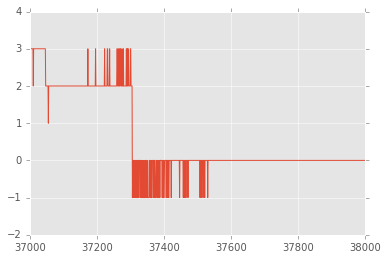

In [110]:
mpl.plts(pmtcwf[1,0], signal_start=37000, signal_end=38000, offset=1)

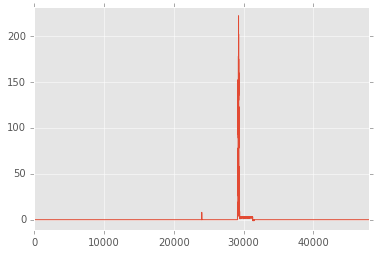

In [113]:
mpl.plts(pmtcwf[7,0], signal_start=0, signal_end=48000, offset=10)

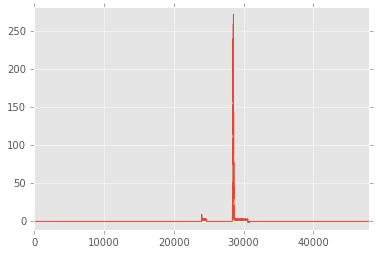

In [114]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

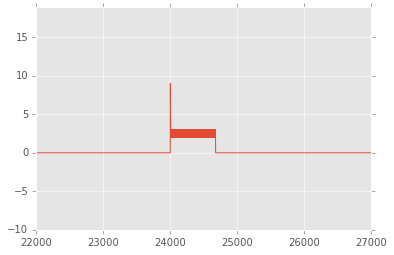

In [115]:
mpl.plts(pmtcwf[2,0], signal_start=22000, signal_end=27000, offset=10)

##### Step in S1

In [116]:
h5f.close()


##### (3,2,5)

In [117]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [118]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 5.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.50174999237 seconds
Leaving ISIDORA. Safe travels!


In [119]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

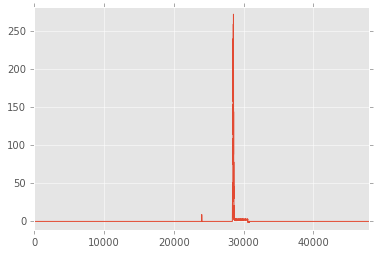

In [120]:
mpl.plts(pmtcwf[2,0], signal_start=0, signal_end=48000, offset=10)

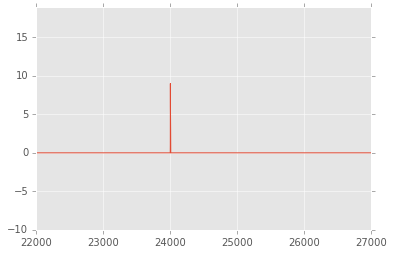

In [121]:
mpl.plts(pmtcwf[2,0], signal_start=22000, signal_end=27000, offset=10)

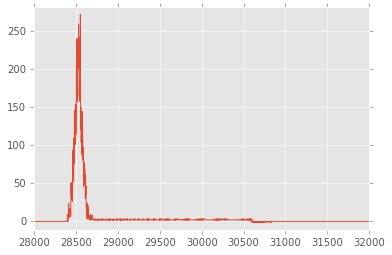

In [123]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

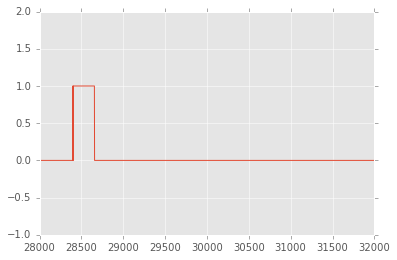

In [125]:
mpl.plts(pulse_on[2], signal_start=28000, signal_end=32000, offset=1)

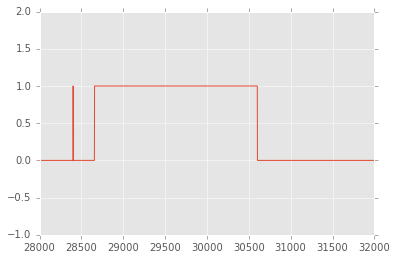

In [126]:
mpl.plts(wait_over[2], signal_start=28000, signal_end=32000, offset=1)

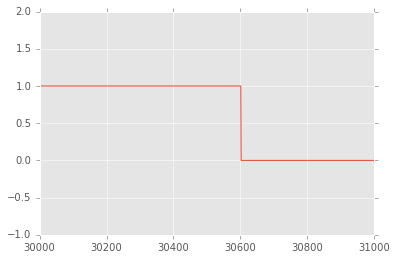

In [127]:
mpl.plts(wait_over[2], signal_start=30000, signal_end=31000, offset=1)

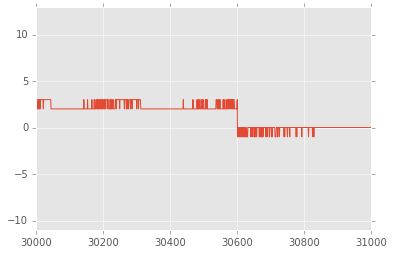

In [128]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

In [129]:
h5f.close()

In [130]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [131]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 7.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.51191306114 seconds
Leaving ISIDORA. Safe travels!


In [132]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

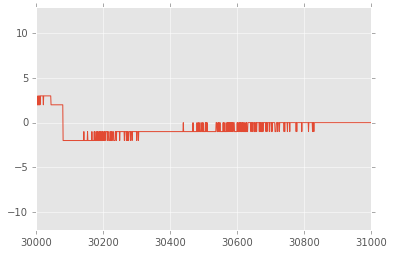

In [133]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

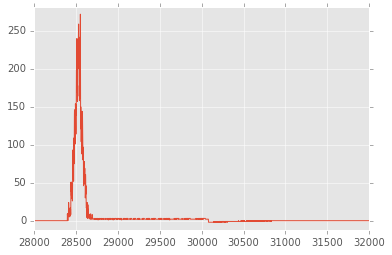

In [134]:
mpl.plts(pmtcwf[2,0], signal_start=28000, signal_end=32000, offset=10)

##### Over compensating! 

In [135]:
h5f.close()

In [136]:
%less ../../../Config/ISIDORA_NA_ZLIB_test.csv

In [137]:
!python ../../../Cities/ISIDORA.py -d INFO -c ../../../Config/ISIDORA_NA_ZLIB_test.csv

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_5bar_10evt_sipmzs.h5 
first event = 0 last event = 10
                    nof events requested = 10 
MAU length = 250
        n_sigma1 = 3.0 n_sigma2 = 2.0 n_sigma2 = 3.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 WF side = 48000 
nof events in input DST = 10 
-->event number =0
-->event number =1
-->event number =2
-->event number =3
-->event number =4
-->event number =5
-->event number =6
-->event number =7
-->event number =8
-->event number =9
ISIDORA has run over 10 events in 4.56934094429 seconds
Leaving ISIDORA. Safe travels!


In [138]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_5bar_10evt_sipmzs.h5')
pmtcwf, mau, pulse_on, wait_over = tbl.get_cwf_vectors(h5f)

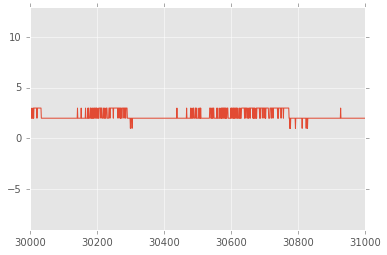

In [139]:
mpl.plts(pmtcwf[2,0], signal_start=30000, signal_end=31000, offset=10)

### Fixing the thresholds
1. th1 = 3 *sigma, to capture correctly the raise of the signal
2. th2 = 2 * sigma, to control recovery of S1 baselines
3. th4 = 5 * sigma to guarantee recovery of S2 baseline

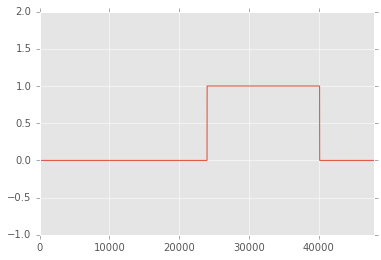

In [144]:
mpl.plts(wait_over[2], signal_start=0, signal_end=48000, offset=1)

##### under compensating! Takes much longer to recover!

### Understanding the BLR parameters

The BLR algorithm is controlled by 3 threshold:
1. thr1 controls when the pulse starts and (together with thr2) where the pulse ends:
2. thr3 controls when the raw signal reaches baseline
3. thr2 is an auxiliare threshold helps to control convergence. 

In more detail, thr1 works as follows

Once pulse_on = 1 the BLR algorithm freezes the MAU (the baseline) and starts recovering signal

The pulse finishes (pulse_on = 0) when the recovered signal falls below trigger line (which is controlled by the baseline and thr2).

Tail compensation is needed to recover the baseline as soon as possible, since another signal can come at any time, but once the recovered signal has dropped below trigger line its energy is fixed. The tail compensation condition is as follows:

If thr3 is zero or too low, often the tail never compensates. Setting it sufficiently large forces the signal to return to baseline, sometimes with a small jump (which should be irrelevant, since the recovered signal is over).

### Tuning parameters

#### "old" Na-22 file

#### thr1 = 5 x sigma, thr2 = 0 x sigma, thr3 = 0 x sigma

In [304]:
h5f.close()

In [306]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 0.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.45076179504 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.43 s, sys: 38.6 ms, total: 2.47 s
Wall time: 2.52 s


In [313]:
def cwf(event=0, pmt=0):
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
    pmtcwf = h5f.root.RD.pmtcwf
    pmtcw = pmtcwf[event, pmt]
    pulse_on = h5f.root.BLR.pulse_on[event]
    wait_over = h5f.root.BLR.wait_over[event]
    acum  = h5f.root.BLR.acum[event] 
    plts(pmtcw, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pulse_on, signal_start=0, signal_end=25000, offset=1)
    plts(wait_over, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5000, signal_end=5500, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=5700, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcw, signal_start=6000, signal_end=9000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=25000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=0, signal_end=2000, offset=1)
    plt.show()
    wait()
    plts(acum, signal_start=7500, signal_end=9000, offset=1)
    plt.show()
    h5f.close()
    

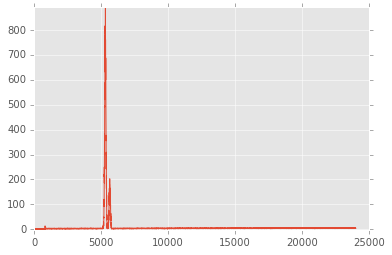

Press a key...


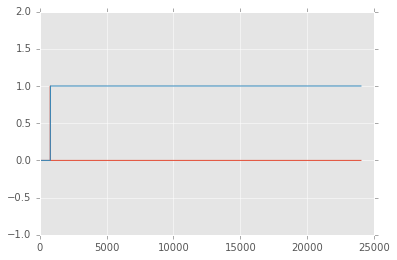

Press a key...


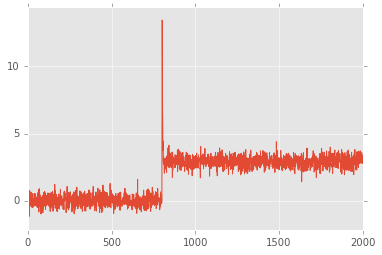

Press a key...


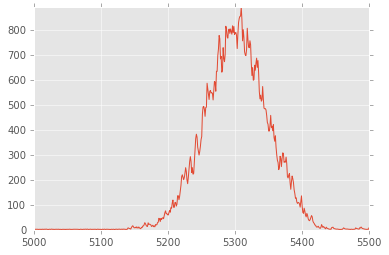

Press a key...


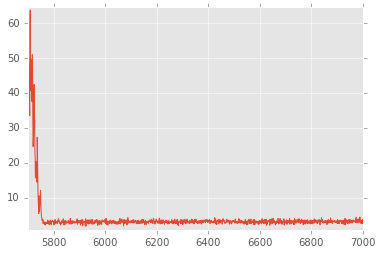

Press a key...


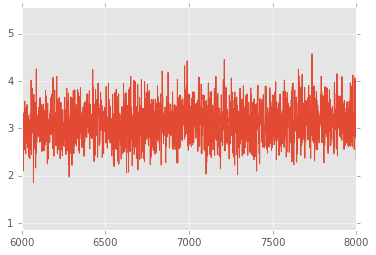

Press a key...


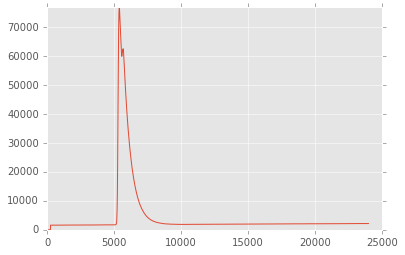

Press a key...


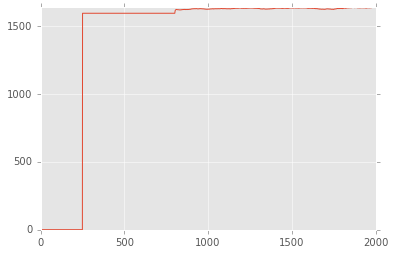

Press a key...


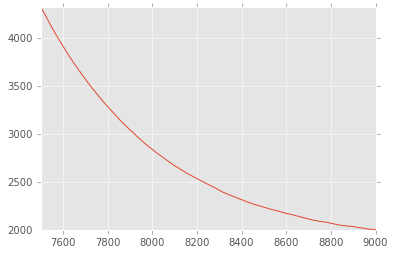

In [308]:
cwf()

#### With nsigma (5,0,0)  the baseline is never fully recovered

### Case (5,0,1)

In [309]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 1.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 2.9679889679 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 2.97 s, sys: 37.9 ms, total: 3.01 s
Wall time: 3.03 s


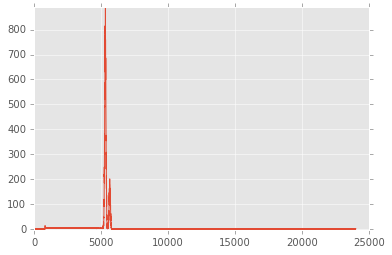

Press a key...


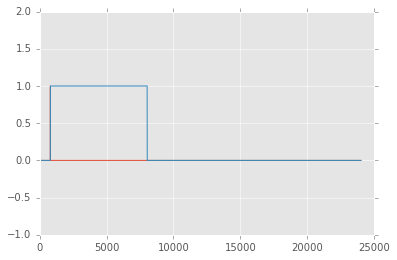

Press a key...


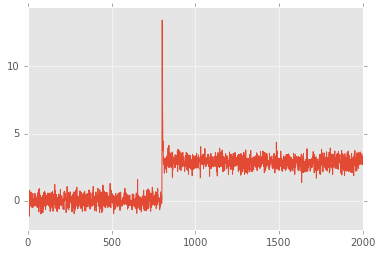

Press a key...


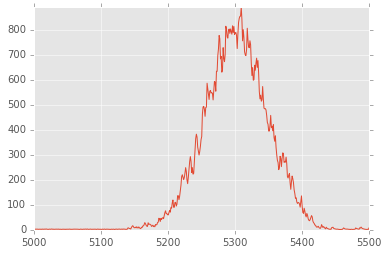

Press a key...


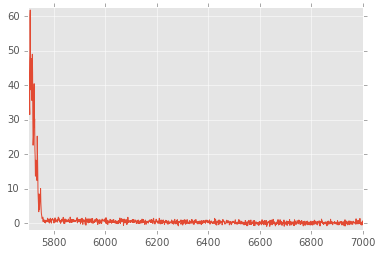

Press a key...


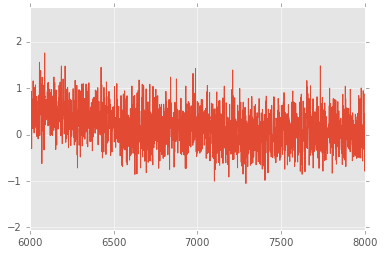

Press a key...


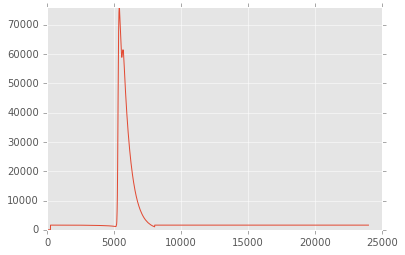

Press a key...


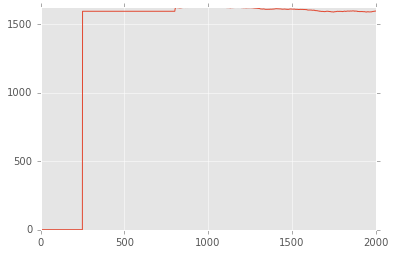

Press a key...


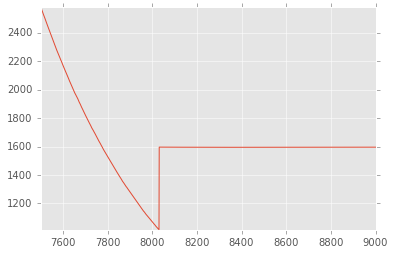

In [310]:
cwf()

#### Case (5,0,1):  The baseline returns to zero by S1 is distorted.

###  Case(5,0,2)

In [311]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 3.0748860836 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 3.07 s, sys: 40.8 ms, total: 3.11 s
Wall time: 3.14 s


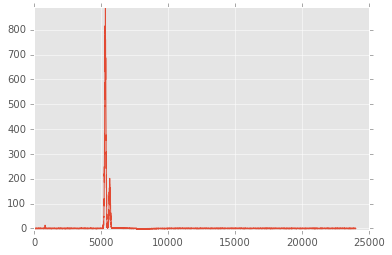

Press a key...


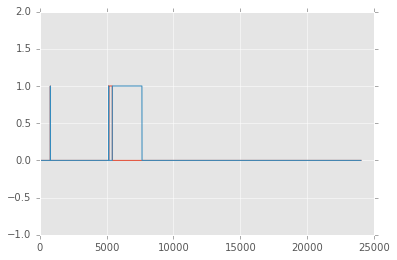

Press a key...


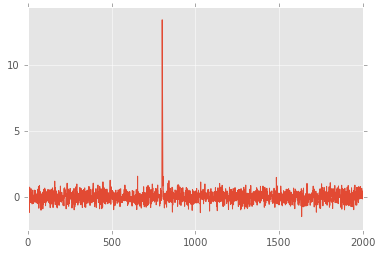

Press a key...


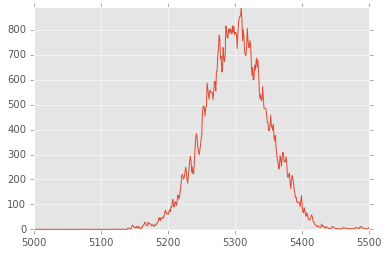

Press a key...


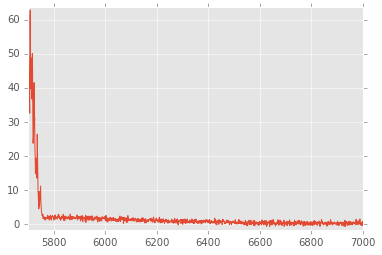

Press a key...


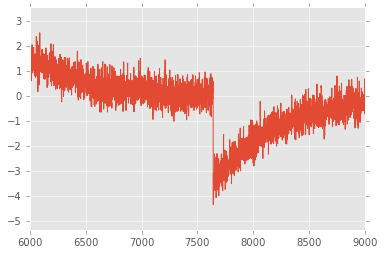

Press a key...


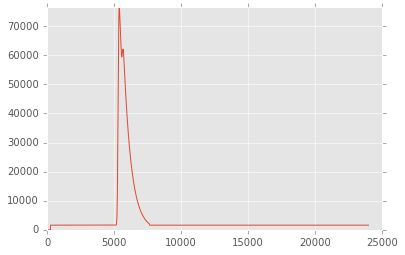

Press a key...


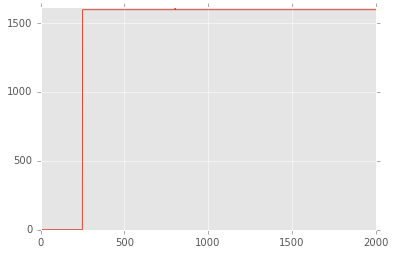

Press a key...


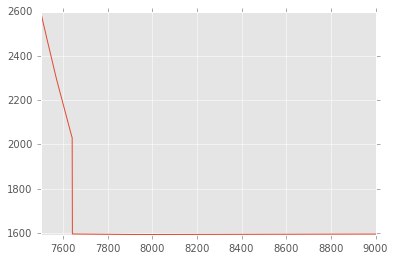

In [314]:
cwf()

### C(5,0,2): S1 is not distorted, wait_over is minimized.

### Test run over 10 events

In [315]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test2.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =WF_Na_ZLIB_evt1000_RWF.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 24000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 31.8485651016 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 31.1 s, sys: 455 ms, total: 31.6 s
Wall time: 32 s


In [316]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_evt1000_RWF.h5', "r+") 
pmtcwf = h5f.root.RD.pmtcwf

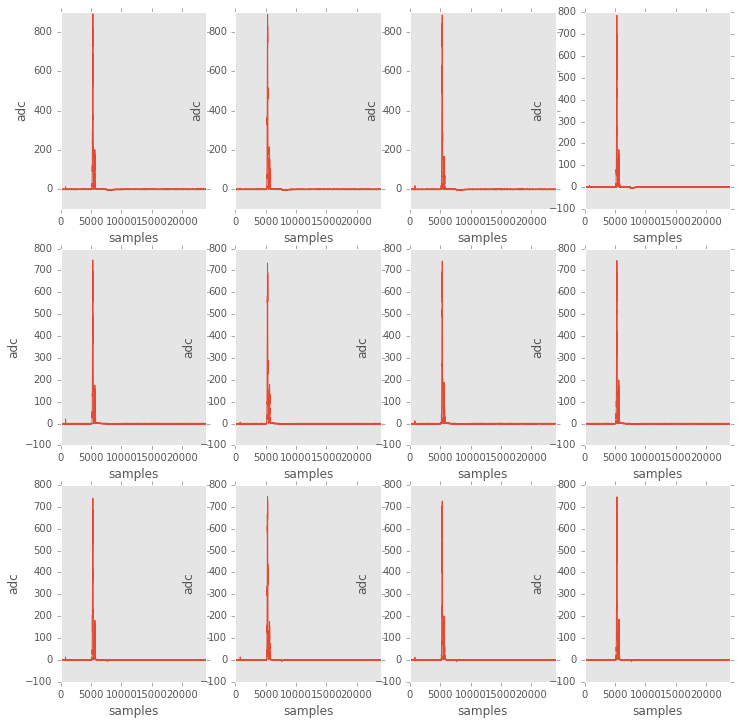

Press a key...


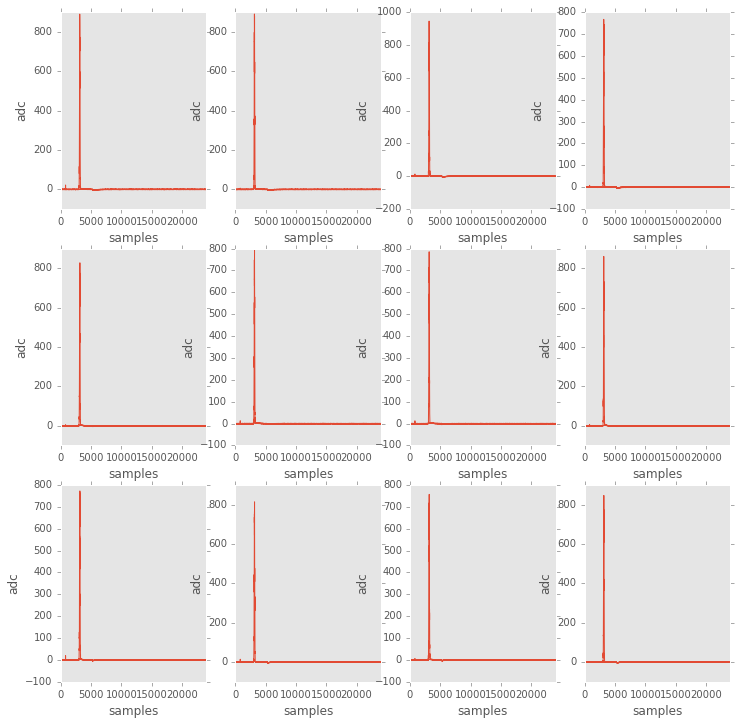

Press a key...


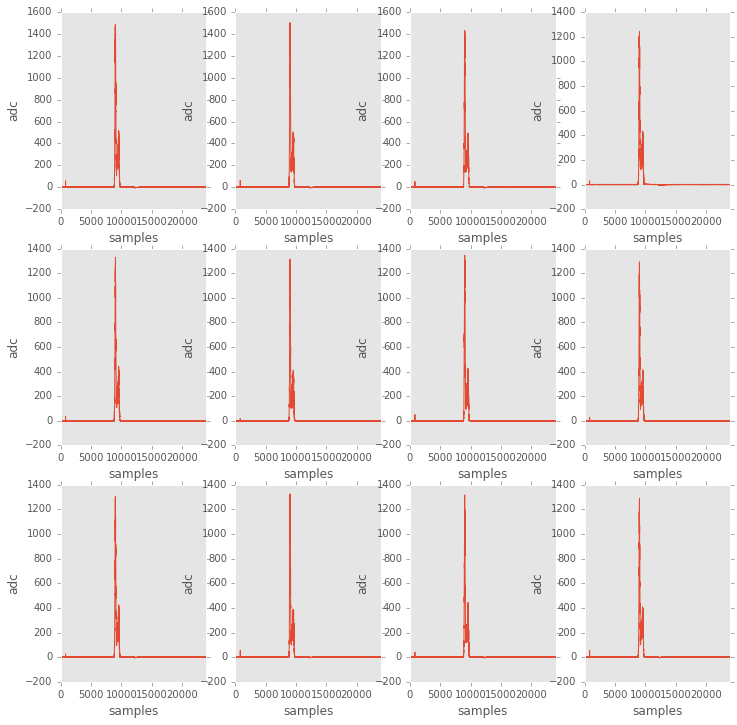

Press a key...


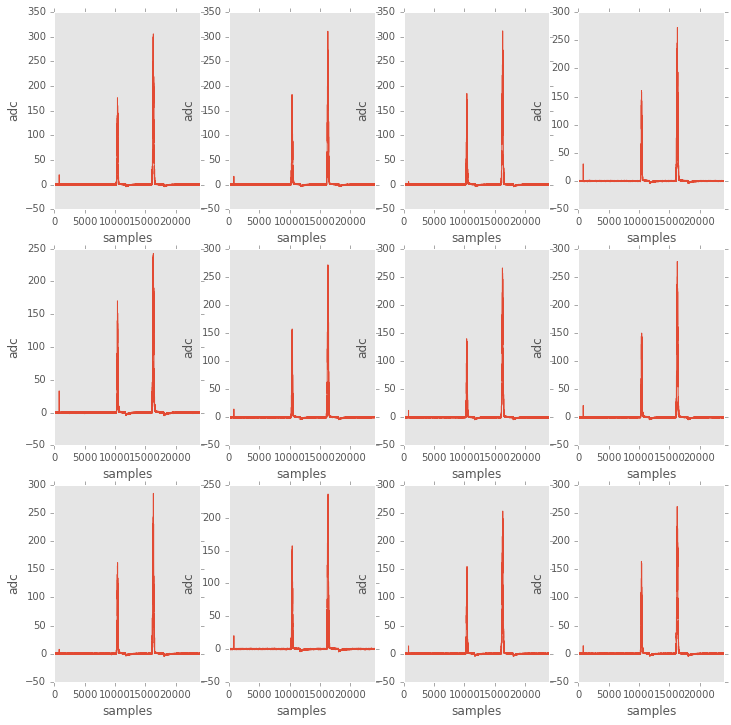

Press a key...


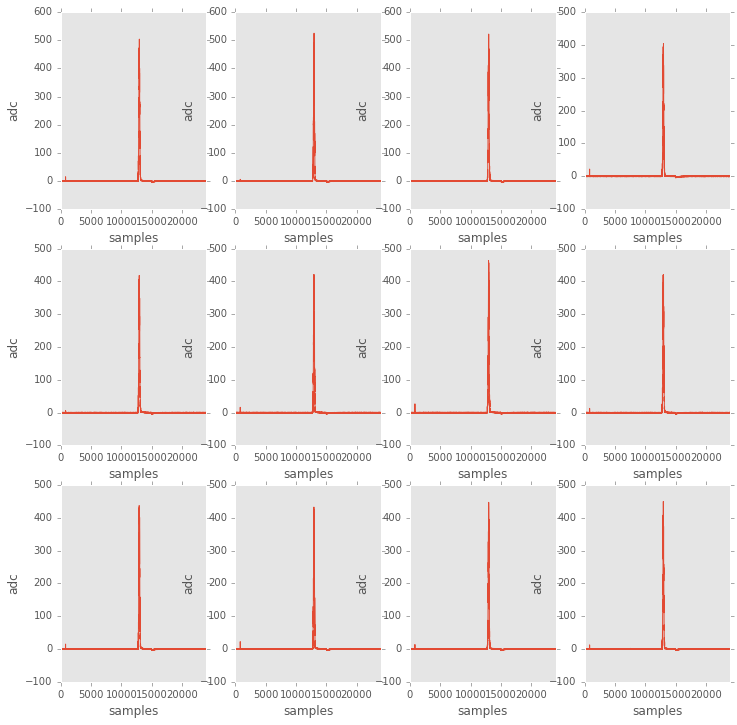

Press a key...


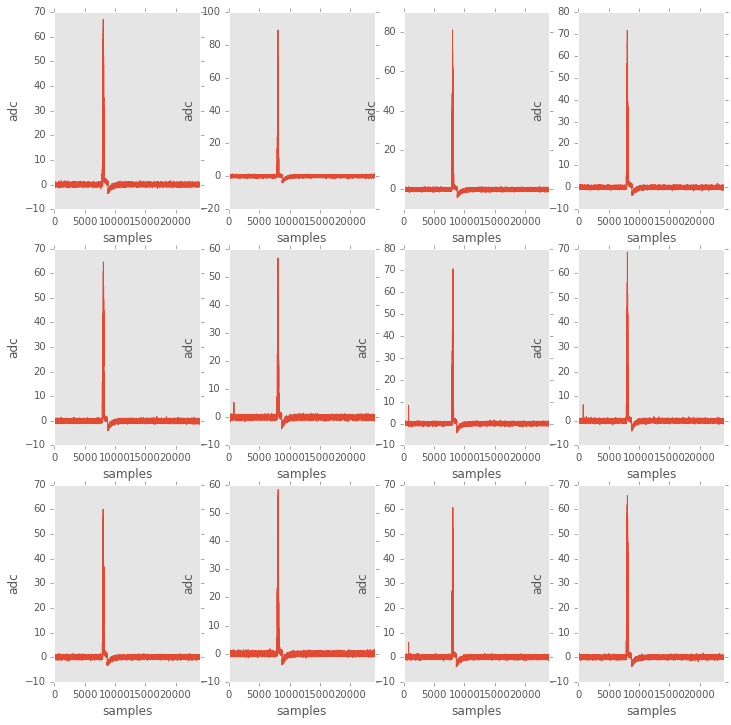

Press a key...


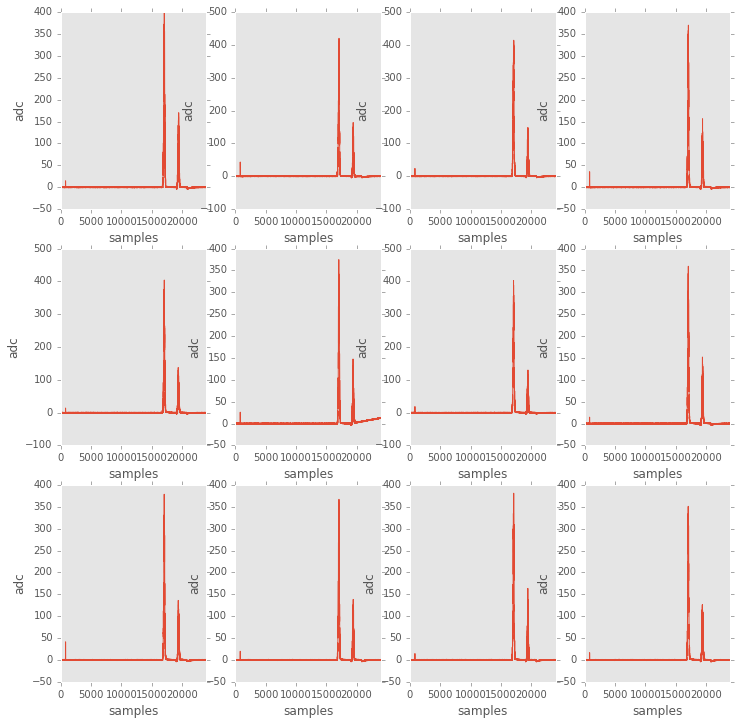

Press a key...


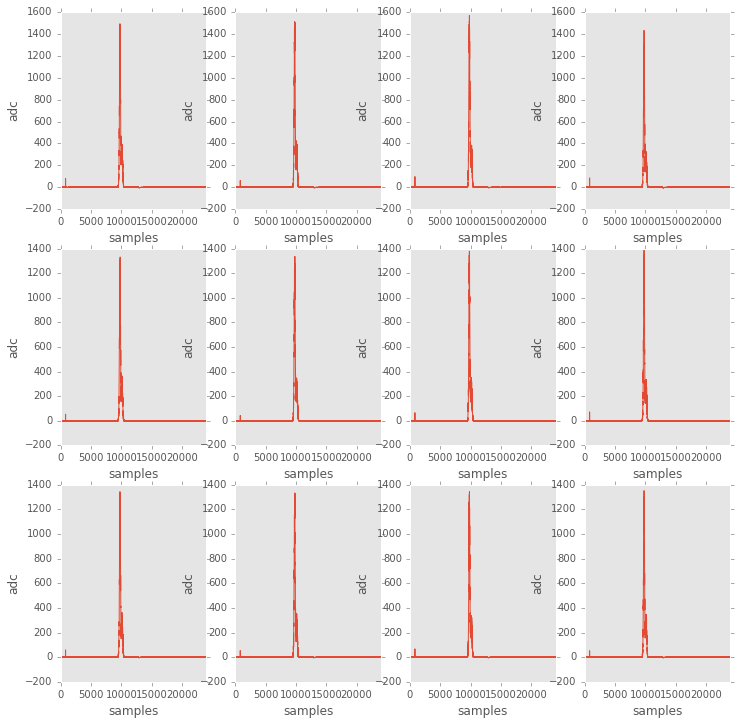

Press a key...


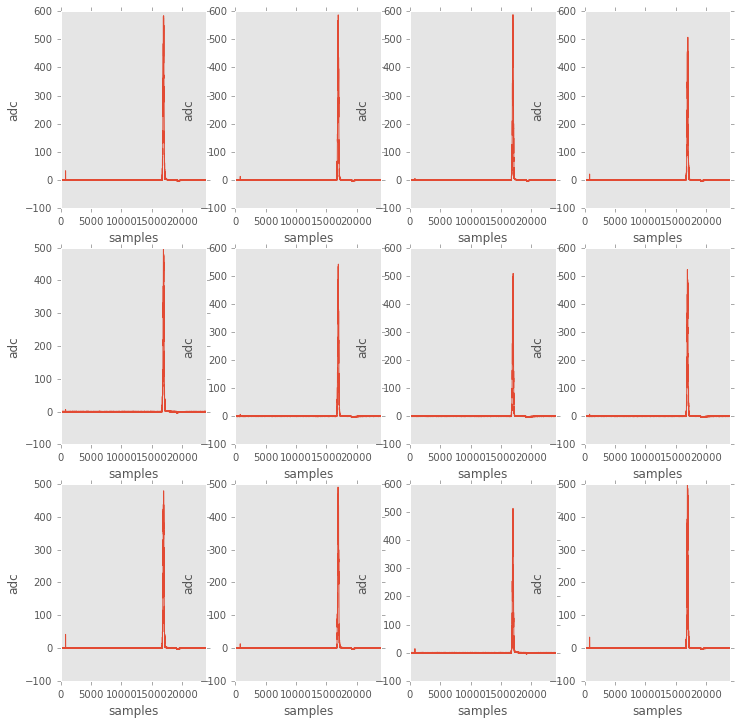

Press a key...


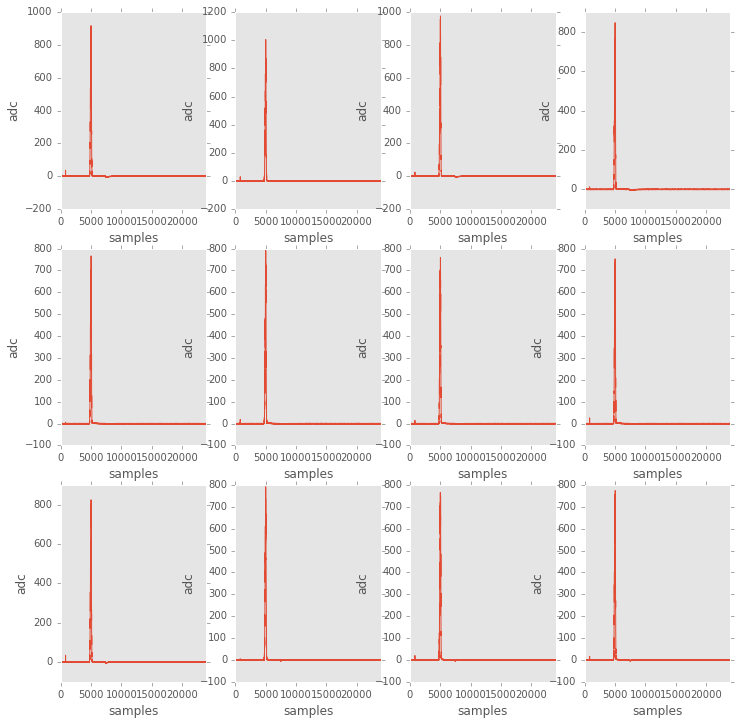

Press a key...


In [317]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

### Test run over new preproc Kr file

In [320]:
h5f.close()

In [322]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5','r+')

In [323]:
pmtrwf = h5f.root.RD.pmtrwf

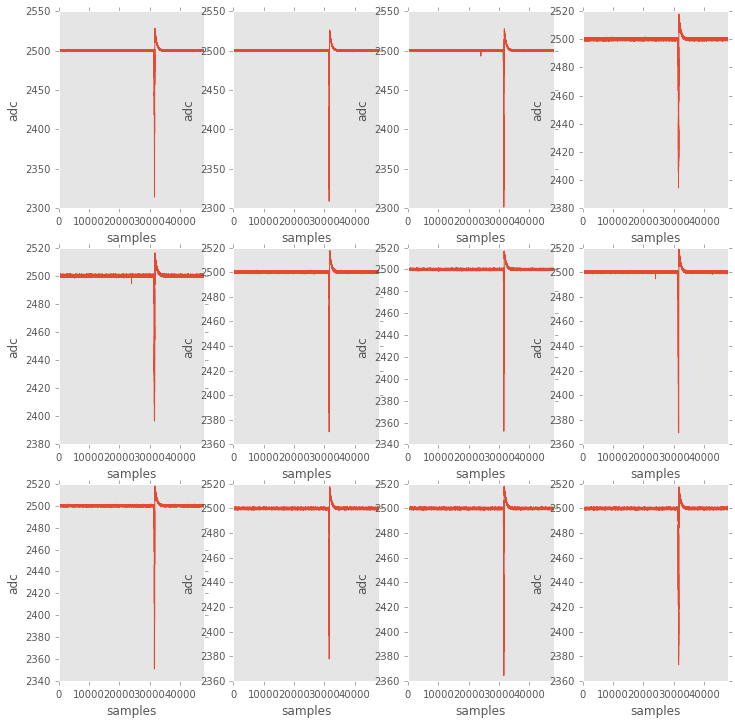

Press a key...


In [324]:
mpl.scan_waveforms(pmtrwf,list_of_events=[0])

In [325]:
h5f.close()

In [326]:
%less ../../Config/ISIDORA_NA_ZLIB_test.csv

### C(5,0,2)

In [346]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 1 nof events requested = 1 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


ISIDORA has run over 0 events in 6.16009998322 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 6.13 s, sys: 119 ms, total: 6.25 s
Wall time: 6.26 s


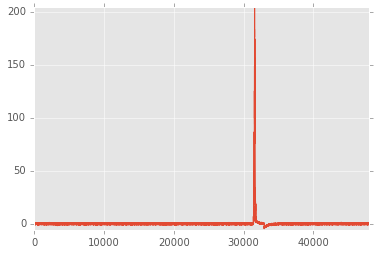

In [347]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf
pulse_on = h5f.root.BLR.pulse_on[0]
wait_over = h5f.root.BLR.wait_over[0]
acum  = h5f.root.BLR.acum[0] 
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=0, signal_end=48000, offset=1)

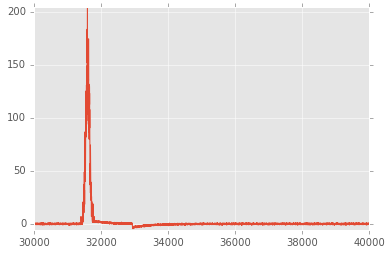

In [349]:
plts(pmtcw, signal_start=30000, signal_end=40000, offset=1)

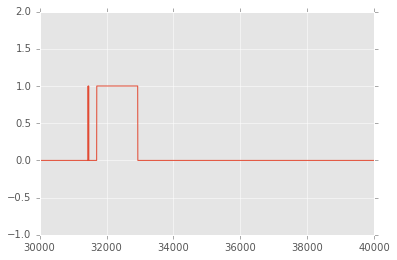

In [350]:
plts(wait_over, signal_start=30000, signal_end=40000, offset=1)

### Running 10 events

In [351]:
%time ISIDORA(['-i','-d','INFO','-c','/Users/jjgomezcadenas/Documents/Development/NEXT/IC/Config/ISIDORA_NA_ZLIB_test.csv'])

Debug level = INFO
input path =/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/; file_in =Kr_ACTIVE_5bar_evt_1000.h5 
first event = 0 last event = 10 nof events requested = 10 
MAU length = 250 n_sigma1 = 5.0 n_sigma2 = 0.0 n_sigma3 = 2.0 
CA  = [ 6.02975448  6.22547194  6.0671337   6.22159457  6.29999787  6.09892384
  6.18289435  6.21775591  6.19306671  6.30518792  6.20359891  6.31231192] nF 
Accumulator Coefficients = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]  
nof PMTs = 12 nof events in input DST = 1000 
lof PMT WF (MC) = 48000 
computing the accumulator coefficients from nominal capacitances
AC = [ 0.0017643   0.00170883  0.00175343  0.0017099   0.00168862  0.00174429
  0.0017206   0.00171095  0.00171778  0.00168723  0.00171486  0.00168533]
INFO:root:-->event number =0


-->event number =0


INFO:root:-->event number =1


-->event number =1


INFO:root:-->event number =2


-->event number =2


INFO:root:-->event number =3


-->event number =3


INFO:root:-->event number =4


-->event number =4


INFO:root:-->event number =5


-->event number =5


INFO:root:-->event number =6


-->event number =6


INFO:root:-->event number =7


-->event number =7


INFO:root:-->event number =8


-->event number =8


INFO:root:-->event number =9


-->event number =9


ISIDORA has run over 9 events in 61.3548669815 seconds
Leaving ISIDORA. Safe travels!
CPU times: user 1min, sys: 799 ms, total: 1min 1s
Wall time: 1min 1s


In [353]:
h5f.close()
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/Kr_ACTIVE_5bar_evt_1000.h5', "r+")
pmtcwf = h5f.root.RD.pmtcwf

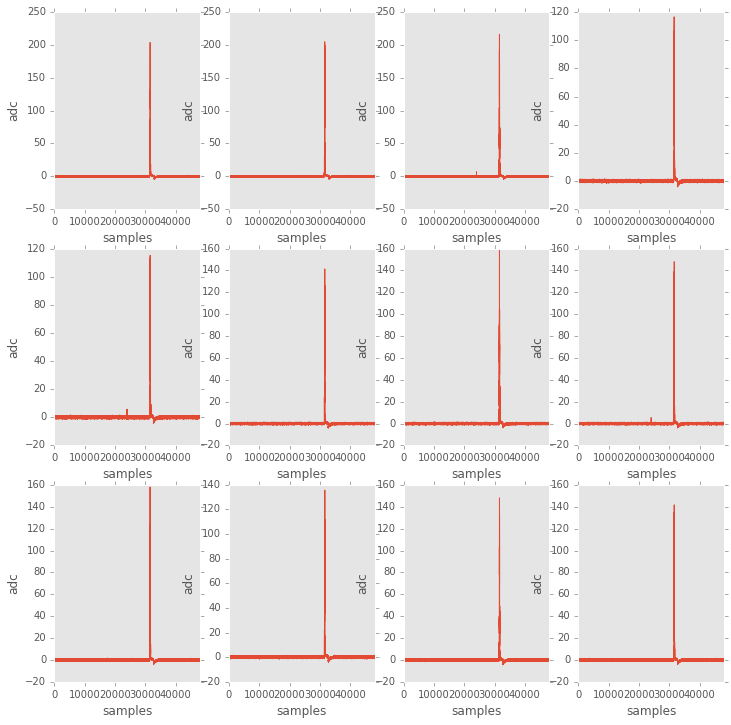

Press a key...


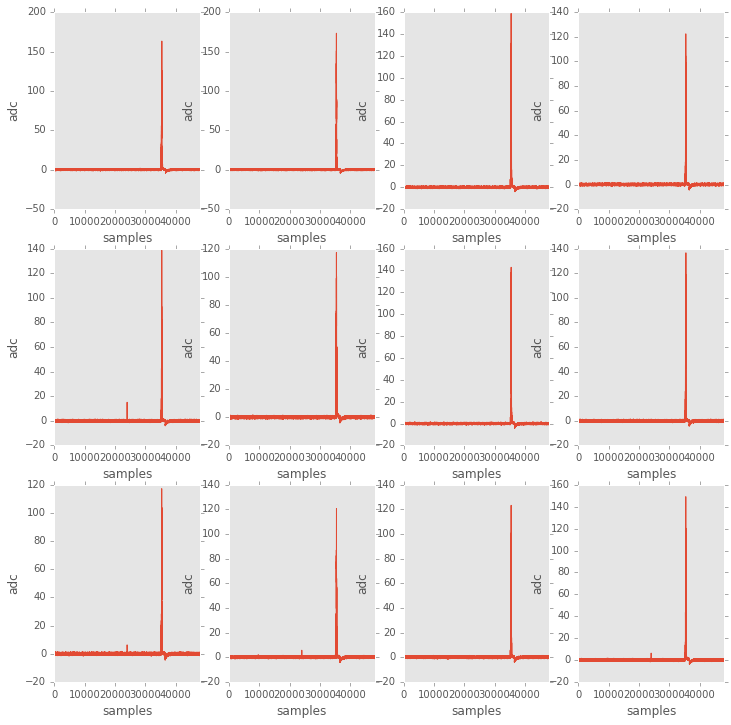

Press a key...


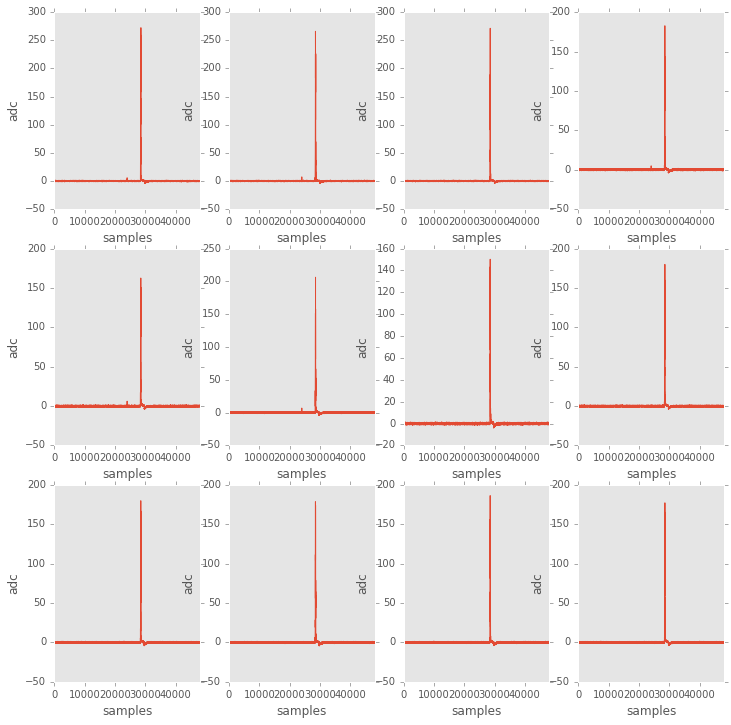

Press a key...


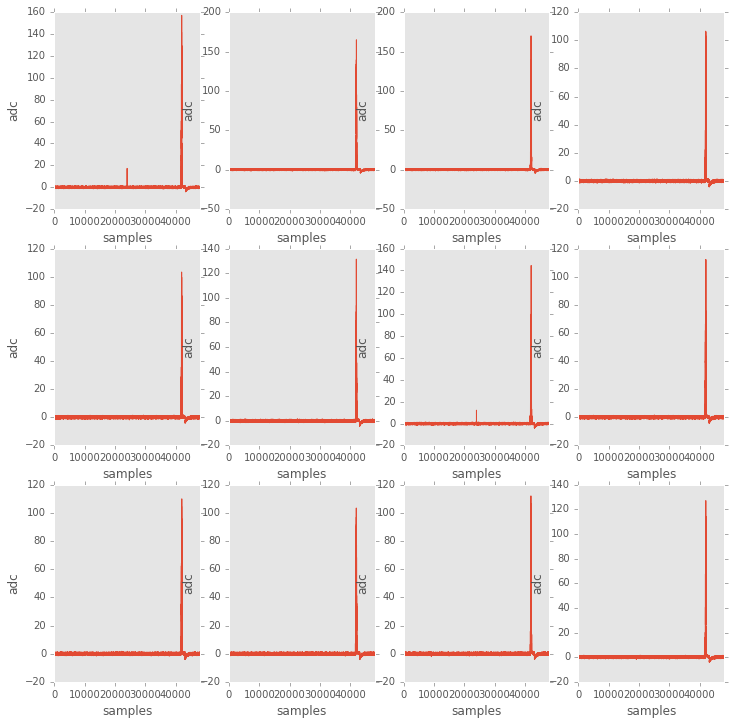

Press a key...


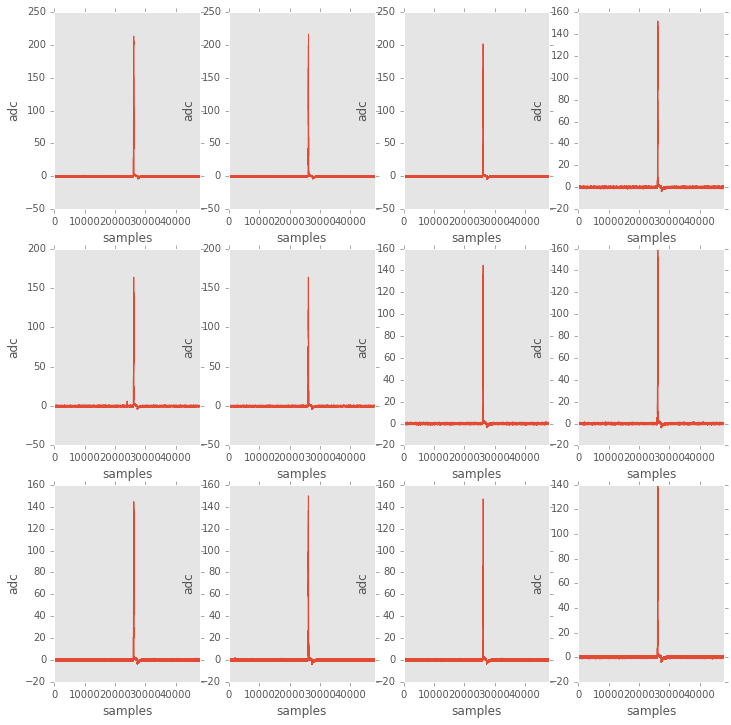

Press a key...


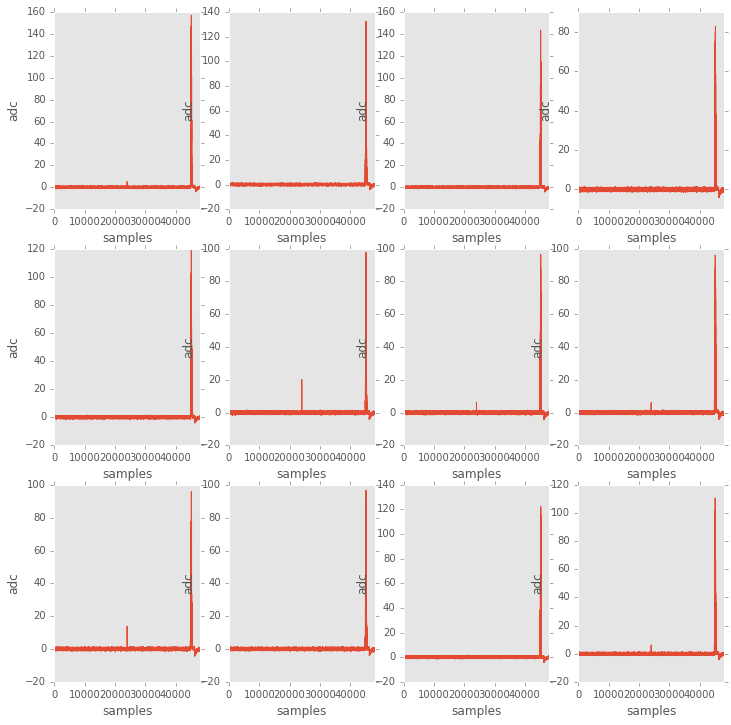

Press a key...


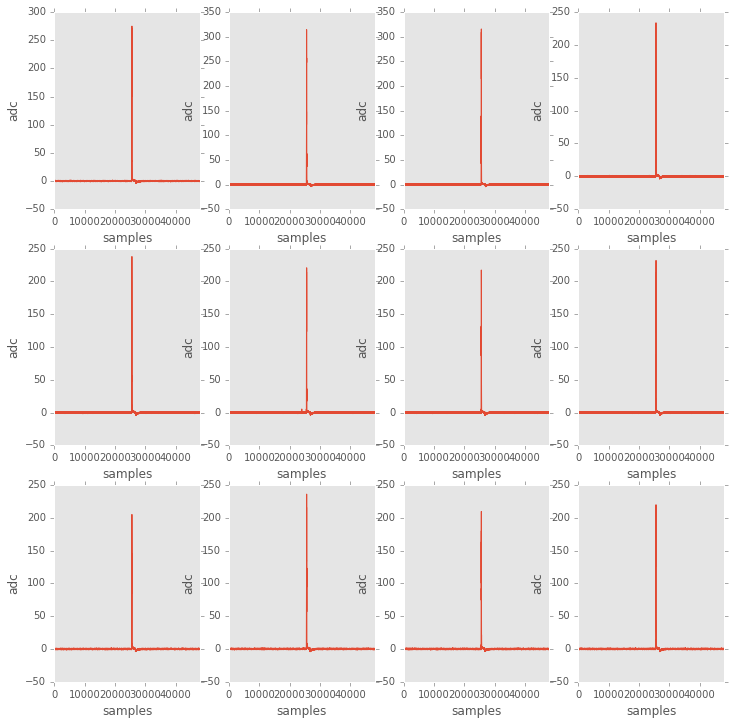

Press a key...


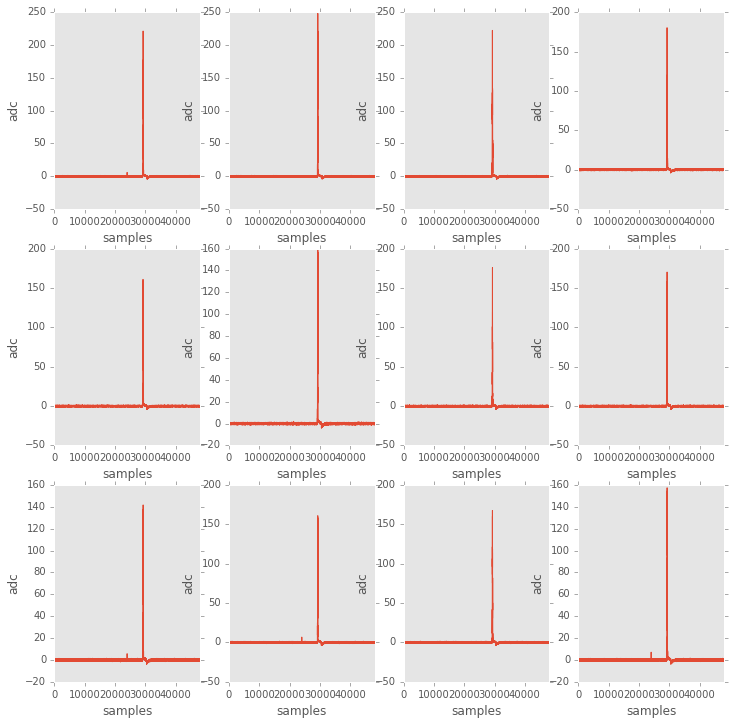

Press a key...


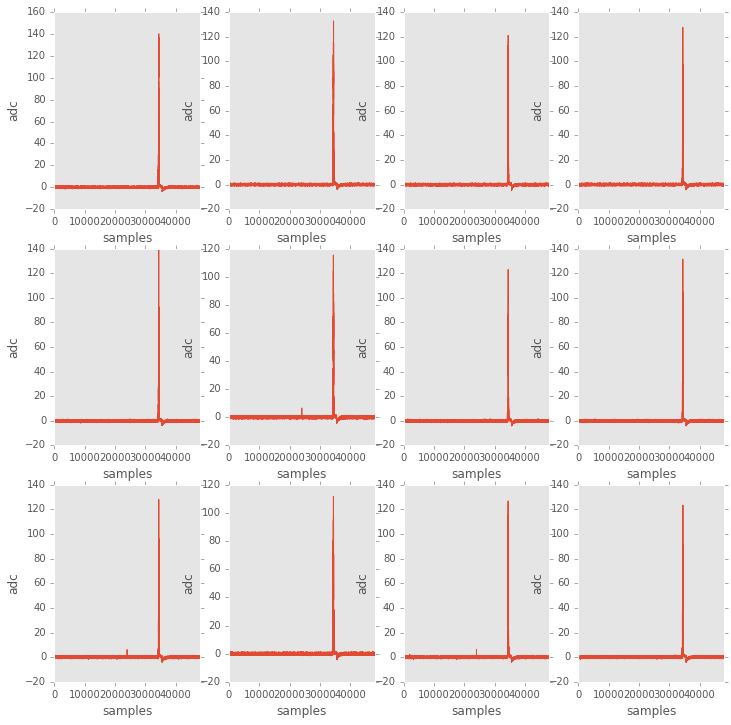

Press a key...


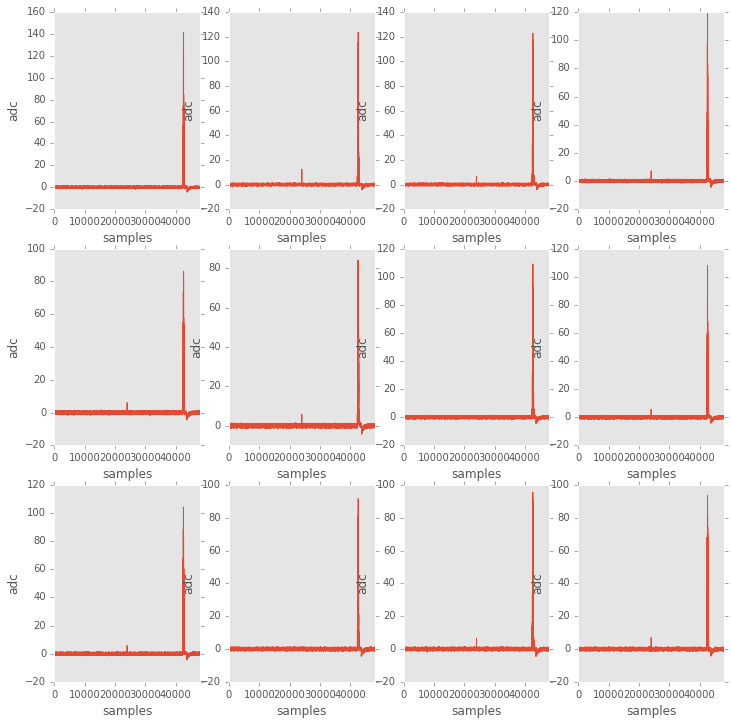

Press a key...


In [354]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(10))

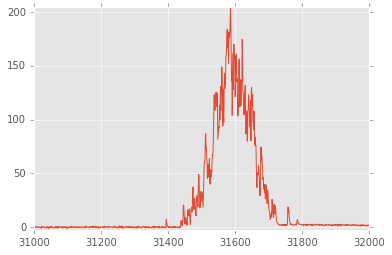

In [355]:
pmtcw = pmtcwf[0, 0]
plts(pmtcw, signal_start=31000, signal_end=32000, offset=1)

In [359]:
def ana_wf():
    h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")
    pmtcwf = h5f.root.RD.pmtcwf
    plts(pmtcwf[0, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[0, 0], signal_start=5750, signal_end=7000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[1, 0], signal_start=3280, signal_end=5000, offset=1)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=0, signal_end=25000, offset=10)
    plt.show()
    wait()
    plts(pmtcwf[2, 0], signal_start=9800, signal_end=11000, offset=1)
    plt.show()
    h5f.close()

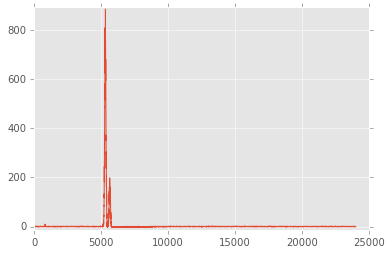

Press a key...


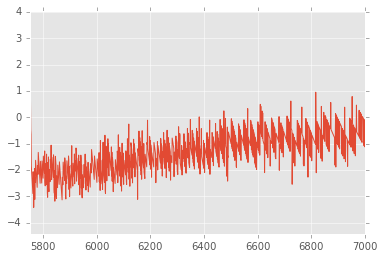

Press a key...


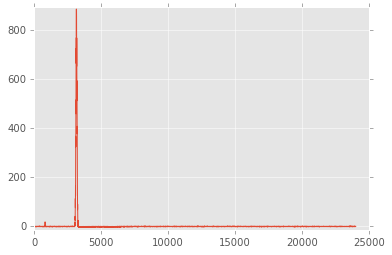

Press a key...


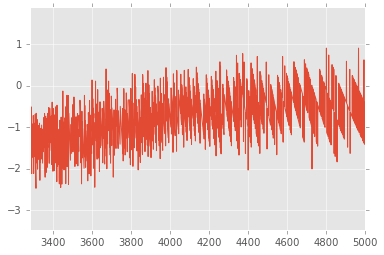

Press a key...


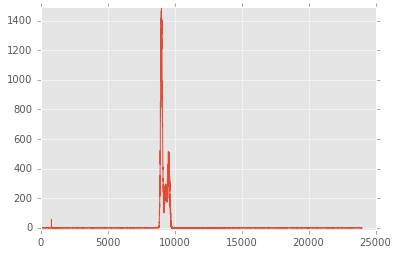

Press a key...


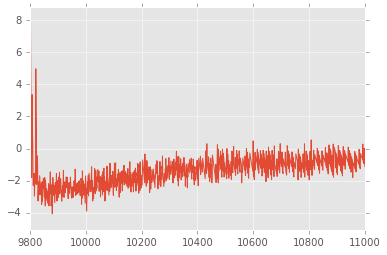

In [360]:
ana_wf()

In [361]:
h5f.close()